In [13]:
# --- Core Libraries ---
import os
import re
import numpy as np
import nibabel as nib
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm

# --- Deep Learning & ML ---
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv3D, MaxPooling3D, Flatten, LSTM, TimeDistributed
import xgboost as xgb

# --- Scikit-learn Utilities ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- GPU Check ---
print("--- GPU Check ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"✅ Found {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        print(f"✅ Your {gpus[0].name.split(':')[-1]} is ready!")
    except RuntimeError as e:
        print(e)
else:
    print("❌ No GPU found. The model will run on the CPU.")

print("\n--- All libraries imported successfully! ---")

--- GPU Check ---
✅ Found 1 Physical GPUs, 1 Logical GPUs
✅ Your 0 is ready!

--- All libraries imported successfully! ---


In [14]:
def load_and_preprocess_acdc_data(data_path, subset='training', target_labels=None, img_size=(128, 128)):
    """
    Loads, filters, and preprocesses the ACDC data from a given path.
    If target_labels is None, it loads all classes.
    """
    images = []
    labels = []
    
    subset_path = os.path.join(data_path, subset)
    patient_folders = sorted([d for d in os.listdir(subset_path) if d.startswith('patient')])
    
    img_regex = re.compile(r'patient\d+_4d\.nii(\.gz)?$')

    print(f"--- Starting to load data from '{subset}' set ---")
    if target_labels:
        print(f"Target labels: {target_labels}")
    else:
        print("Target labels: All")
        
    for patient_dir in tqdm(patient_folders, desc=f"Processing {subset} data"):
        patient_path = os.path.join(subset_path, patient_dir)
        
        try:
            # --- 1. Extract the Label ---
            info_path = os.path.join(patient_path, 'Info.cfg')
            with open(info_path, 'r') as f:
                lines = f.readlines()
            label = next(line.split(':')[1].strip() for line in lines if line.startswith('Group'))

            # --- 2. Filter for Target Labels (or load all) ---
            if target_labels is None or label in target_labels:
                # --- 3. Load the 4D Image ---
                img_file_name = next(f for f in os.listdir(patient_path) if img_regex.match(f))
                img_path = os.path.join(patient_path, img_file_name)
                img_nifti = nib.load(img_path)
                img_data = img_nifti.get_fdata().astype(np.float32)
                
                # --- 4. Preprocess the Image ---
                resized_slices = []
                num_frames = img_data.shape[3]

                for t in range(num_frames):
                    vol_at_t = img_data[:, :, :, t]
                    vol_at_t_ch = np.expand_dims(vol_at_t, axis=-1)
                    vol_at_t_ch_transposed = tf.transpose(vol_at_t_ch, [2, 0, 1, 3])
                    resized_vol = tf.image.resize(vol_at_t_ch_transposed, img_size)
                    resized_vol_transposed = tf.transpose(resized_vol, [1, 2, 0, 3])
                    resized_slices.append(tf.squeeze(resized_vol_transposed, axis=-1).numpy())
                
                processed_img = np.stack(resized_slices, axis=-1)

                min_val, max_val = np.min(processed_img), np.max(processed_img)
                if max_val > min_val:
                    processed_img = (processed_img - min_val) / (max_val - min_val)
                
                processed_img = np.transpose(processed_img, (3, 0, 1, 2))
                processed_img = np.expand_dims(processed_img, axis=-1)
                
                images.append(processed_img)
                labels.append(label)

        except (StopIteration, FileNotFoundError, Exception) as e:
            print(f"\nCould not process {patient_path}. Reason: {e}. Skipping.")
            
    print(f"\n--- Finished processing. Found {len(images)} samples. ---")
    return images, labels

In [3]:
# --- Configuration for our Binary Model ---
ACDC_DATA_PATH = 'data'
TARGET_LABELS = ['HCM', 'DCM']
IMG_SIZE = (64, 64) # Using 64x64 is the safest option for a 4GB GPU.

# These lists will store the 'map' to our data
all_file_paths = []
all_labels = []

# --- Scan folders and collect file paths and corresponding labels ---
subset_path = os.path.join(ACDC_DATA_PATH, 'training')
patient_folders = sorted([d for d in os.listdir(subset_path) if d.startswith('patient')])
img_regex = re.compile(r'patient\d+_4d\.nii(\.gz)?$')

print("--- Scanning for files and labels ---")
for patient_dir in tqdm(patient_folders, desc="Scanning folders"):
    patient_path = os.path.join(subset_path, patient_dir)
    try:
        # Read the label from the Info.cfg file
        info_path = os.path.join(patient_path, 'Info.cfg')
        with open(info_path, 'r') as f:
            lines = f.readlines()
        label = next(line.split(':')[1].strip() for line in lines if line.startswith('Group'))

        # If the label is one we are targeting, store its path and label
        if label in TARGET_LABELS:
            img_file_name = next(f for f in os.listdir(patient_path) if img_regex.match(f))
            img_path = os.path.join(patient_path, img_file_name)
            
            all_file_paths.append(img_path)
            all_labels.append(label)
    except (StopIteration, FileNotFoundError):
        # Skip folders that might be missing files
        continue

# --- Encode the string labels into numbers (0, 1) ---
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)
print(f"\nFound {len(all_file_paths)} total samples for {TARGET_LABELS}.")
print(f"Labels encoded. Classes: {le.classes_}")

# --- Split the file paths and labels into training and validation sets ---
# This is very fast and memory-efficient because we are only splitting lists of strings.
paths_train, paths_val, y_train, y_val = train_test_split(
    all_file_paths, encoded_labels,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels # Ensures balanced classes in both sets
)

print(f"\nTraining samples: {len(paths_train)}, Validation samples: {len(paths_val)}")

--- Scanning for files and labels ---


Scanning folders:   0%|          | 0/100 [00:00<?, ?it/s]


Found 40 total samples for ['HCM', 'DCM'].
Labels encoded. Classes: ['DCM' 'HCM']

Training samples: 32, Validation samples: 8


In [15]:
# --- 1. Define Augmentation Layers ONCE, outside the functions ---
# We create the stateful layers here so they are only created once.
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomWidth(0.05),
    tf.keras.layers.RandomHeight(0.05),
    tf.keras.layers.RandomZoom(0.05),
    # --- FIX: Add a Resizing layer to ensure all outputs have the same shape ---
    tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
])

# --- 2. Define Augmentation and Parsing Functions ---
# Note: The `parse_image` function is assumed to be defined in a previous cell.

def augment_slice(slice_2d):
    """Applies pre-defined augmentation layers to a single 2D slice."""
    slice_3d = tf.expand_dims(slice_2d, axis=-1)
    augmented_slice_3d = data_augmentation_layers(slice_3d, training=True)
    return tf.squeeze(augmented_slice_3d, axis=-1)

def parse_image_and_augment(file_path, label):
    """Loads an image and then applies augmentation."""
    img_tensor = parse_image(file_path)
    
    def _augment_volume_in_time(volume_4d):
        original_shape = tf.shape(volume_4d)
        t, h, w, z = original_shape[0], original_shape[1], original_shape[2], original_shape[3]
        
        slices_2d_batch = tf.reshape(tf.squeeze(volume_4d, axis=-1), [-1, h, w])
        augmented_slices_2d_batch = tf.map_fn(augment_slice, slices_2d_batch)
        
        augmented_volume = tf.reshape(augmented_slices_2d_batch, (t, h, w, z))
        return tf.expand_dims(augmented_volume, axis=-1)

    augmented_img = _augment_volume_in_time(img_tensor)
    return augmented_img, label

# --- 3. Build the Pipelines with Augmentation ---
def configure_augmented_dataset(paths, labels, shuffle=False):
    """Configures the tf.data pipeline, applying augmentation only to the training set."""
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
        
    if shuffle: # Only augment training data
        ds = ds.map(parse_image_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
    else: # Don't augment validation data
        ds = ds.map(lambda p, l: (parse_image(p), l), num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.padded_batch(
        batch_size=1, 
        padded_shapes=([None, IMG_SIZE[0], IMG_SIZE[1], None, 1], [])
    )
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# --- Create the final augmented training and regular validation datasets ---
train_ds_aug = configure_augmented_dataset(paths_train_mc, y_train_mc, shuffle=True)
val_ds_aug = configure_augmented_dataset(paths_val_mc, y_val_mc)

print("\n✅ Augmented tf.data pipelines created successfully.")

NameError: name 'paths_train_mc' is not defined

In [ ]:
# --- Build the model with flexible input shapes ---
INPUT_SHAPE = (None, IMG_SIZE[0], IMG_SIZE[1], None, 1)

def create_st_model(input_shape):
    """
    Creates a simpler 3D CNN-LSTM model using GlobalAveragePooling3D
    to handle variable input slices.
    """
    inputs = Input(shape=input_shape)

    # Spatio-Temporal Feature Extraction (3D CNN part)
    cnn = TimeDistributed(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding='same'))(inputs)
    cnn = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2)))(cnn)
    
    cnn = TimeDistributed(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding='same'))(cnn)
    cnn = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2)))(cnn)

    # --- FIX: Replace Flatten with GlobalAveragePooling3D ---
    # This layer averages the spatial dimensions, creating a fixed-size vector
    # for each time step, regardless of the number of slices.
    cnn = TimeDistributed(tf.keras.layers.GlobalAveragePooling3D())(cnn)

    # Temporal Feature Aggregation (LSTM part)
    lstm = LSTM(32, return_sequences=False)(cnn)

    # Output Layer for Binary Classification
    outputs = Dense(1, activation='sigmoid')(lstm)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# --- Create and Compile the Model ---
model_binary = create_st_model(INPUT_SHAPE)

model_binary.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("--- Simplified Binary Model Architecture (Flexible Input) ---")
model_binary.summary()

--- Simplified Binary Model Architecture (Flexible Input) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ None, 1)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, None, 64, 64,   │           224 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, None, 32, 32,   │             0 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, None, 32, 32,   │         3,472 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, None, 16, 16,   │             0 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,001 (39.07 KB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # --- Set Training Parameters ---
# EPOCHS = 20 # Let's train for a few more epochs with our simpler model
# # The batch size is handled by our tf.data pipeline, so we don't set it here.

# print("--- Starting Model Training with tf.data pipeline ---")

# # --- Train the model ---
# # We feed our efficient tf.data.Dataset objects directly to the fit method.
# history_binary = model_binary.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     verbose=1 # This will show a progress bar for each epoch
# )

# print("\n--- Model Training Complete ---")

--- Starting Model Training with tf.data pipeline ---
Epoch 1/20


I0000 00:00:1758552615.297780   17590 cuda_dnn.cc:529] Loaded cuDNN version 91002


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2583 - loss: 0.6963WARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.3750 - loss: 0.6965 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.4688 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.5000 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.5000 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.5000 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.4688 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - ac

In [ ]:
# import pickle

# # --- Create a directory to save our models and history ---
# os.makedirs('saved_models', exist_ok=True)

# # --- Define file paths ---
# MODEL_PATH = 'saved_models/binary_classifier_model.keras'
# HISTORY_PATH = 'saved_models/binary_classifier_history.pkl'

# # --- Save the entire model ---
# # This saves the architecture, the learned weights, and the optimizer state.
# model_binary.save(MODEL_PATH)

# # --- Save the training history ---
# # We use the 'pickle' library to save the history dictionary.
# with open(HISTORY_PATH, 'wb') as file:
#     pickle.dump(history_binary.history, file)

# print(f"✅ Model saved to: {MODEL_PATH}")
# print(f"✅ Training history saved to: {HISTORY_PATH}")

✅ Model saved to: saved_models/binary_classifier_model.keras
✅ Training history saved to: saved_models/binary_classifier_history.pkl


✅ Accuracy plot saved to 'binary_model_accuracy_plot.png'


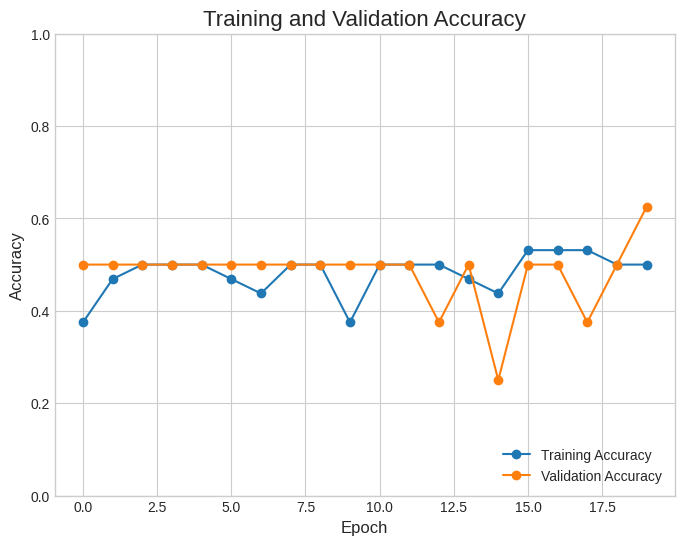

✅ Loss plot saved to 'binary_model_loss_plot.png'


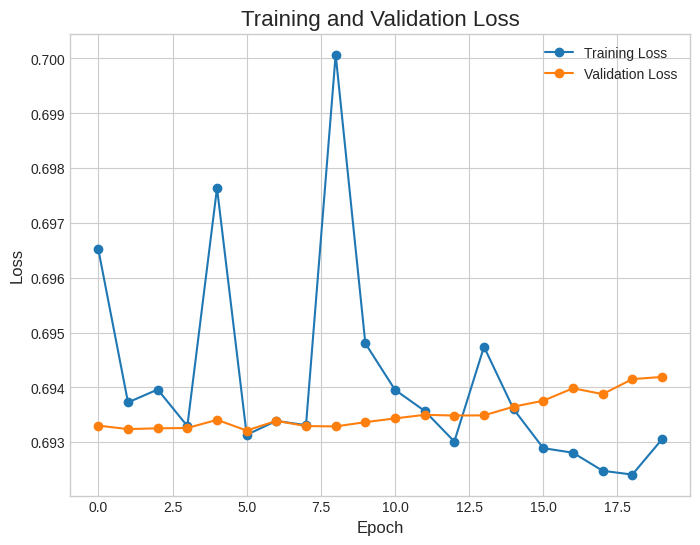

In [ ]:
# --- Plot the training and validation accuracy and loss ---
if 'history_binary' in locals():
    acc = history_binary.history['accuracy']
    val_acc = history_binary.history['val_accuracy']
    loss = history_binary.history['loss']
    val_loss = history_binary.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.style.use('seaborn-v0_8-whitegrid')

    # --- 1. Create and Save the Accuracy Plot ---
    plt.figure(figsize=(8, 6)) # Create a new figure for the accuracy plot
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim([0, 1])
    
    # Save the figure to a file
    plt.savefig('binary_model_accuracy_plot.png', dpi=300, bbox_inches='tight')
    print("✅ Accuracy plot saved to 'binary_model_accuracy_plot.png'")
    plt.show()


    # --- 2. Create and Save the Loss Plot ---
    plt.figure(figsize=(8, 6)) # Create a new figure for the loss plot
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Save the figure to a file
    plt.savefig('binary_model_loss_plot.png', dpi=300, bbox_inches='tight')
    print("✅ Loss plot saved to 'binary_model_loss_plot.png'")
    plt.show()

else:
    print("Training history not found. Please run the training cell (Cell 6) first.")

In [12]:
# --- Create a new model that outputs the LSTM features ---
# The name of the LSTM layer might change if you re-run the model creation cell.
# Always check the model.summary() output for the current correct name.

# FIX: Changed 'lstm_1' to 'lstm_2' to match the current model.
FEATURE_LAYER_NAME = 'lstm_2' 

feature_extractor = Model(
    inputs=model_binary.input,
    outputs=model_binary.get_layer(FEATURE_LAYER_NAME).output
)

# Compile the feature extractor (compilation is needed to run predict)
feature_extractor.compile()

print(f"--- Feature Extractor Model (outputting from '{FEATURE_LAYER_NAME}') ---")
feature_extractor.summary()

NameError: name 'model_binary' is not defined

In [11]:
print("--- Extracting features from the training set ---")
# The .predict() method will automatically iterate through our tf.data pipeline
X_train_features = feature_extractor.predict(train_ds)

print("\n--- Extracting features from the validation set ---")
X_val_features = feature_extractor.predict(val_ds)

print("\n--- Feature Extraction Complete ---")
print(f"Shape of training features: {X_train_features.shape}")
print(f"Shape of validation features: {X_val_features.shape}")

--- Extracting features from the training set ---


NameError: name 'feature_extractor' is not defined

In [10]:
# --- Create and Train the XGBoost Classifier ---
print("--- Training the XGBoost Classifier ---")

# 1. Instantiate the XGBoost model with standard parameters for binary classification
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic', 
    use_label_encoder=False, 
    eval_metric='logloss'
)

# 2. Train the model on our extracted features and original labels
xgb_classifier.fit(X_train_features, y_train)

print("\n✅ XGBoost model training complete.")

--- Training the XGBoost Classifier ---


NameError: name 'X_train_features' is not defined

In [9]:
# --- Make predictions on the validation set features ---
y_pred_xgb = xgb_classifier.predict(X_val_features)

# --- Generate and print the classification report ---
print("--- XGBoost Classifier Performance on Validation Set ---")
report = classification_report(y_val, y_pred_xgb, target_names=le.classes_)
print(report)

NameError: name 'xgb_classifier' is not defined

In [ ]:
# --- Define the file path for the XGBoost model ---
XGB_MODEL_PATH = 'saved_models/xgb_classifier_model.json'

# --- Save the trained XGBoost model ---
xgb_classifier.save_model(XGB_MODEL_PATH)

print(f"✅ XGBoost classifier saved to: {XGB_MODEL_PATH}")

✅ XGBoost classifier saved to: saved_models/xgb_classifier_model.json


✅ Confusion matrix plot saved to 'xgb_confusion_matrix.png'


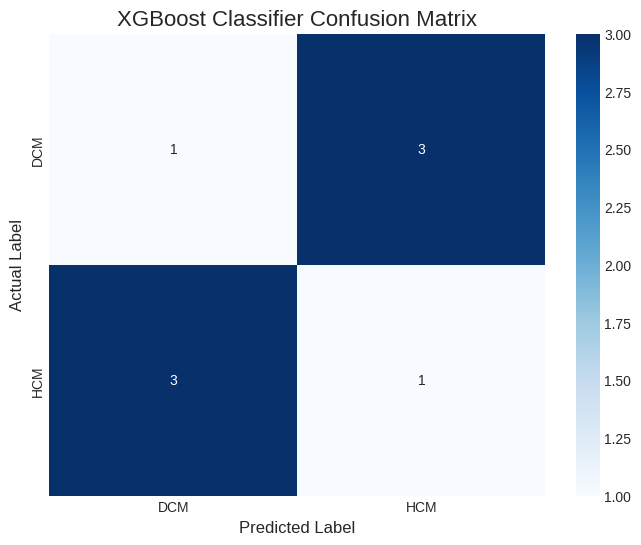

In [ ]:
# --- Calculate the Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred_xgb)

# --- Plot the Confusion Matrix as a Heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('XGBoost Classifier Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# --- Save the plot for your paper ---
plt.savefig('xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Confusion matrix plot saved to 'xgb_confusion_matrix.png'")
plt.show()

In [ ]:
# --- Configuration for our Multi-Class Model ---
# We'll stick with the memory-safe image size
IMG_SIZE = (64, 64) 

# --- Load all 5 classes by leaving target_labels as None ---
images_multiclass, labels_multiclass = load_and_preprocess_acdc_data(
    data_path=ACDC_DATA_PATH, 
    subset='training', 
    target_labels=None, # <-- This tells the function to load all classes
    img_size=IMG_SIZE
)

# --- Verification Step ---
if images_multiclass:
    unique_labels, counts = np.unique(labels_multiclass, return_counts=True)
    print(f"\n✅ Successfully loaded {len(images_multiclass)} samples for the multi-class model.")
    print("Label distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  - {label}: {count} samples")
else:
    print("\n❌ No images were loaded for the multi-class model.")

--- Starting to load data from 'training' set ---
Target labels: All


Processing training data:   0%|          | 0/100 [00:00<?, ?it/s]


--- Finished processing. Found 100 samples. ---

✅ Successfully loaded 100 samples for the multi-class model.
Label distribution:
  - DCM: 20 samples
  - HCM: 20 samples
  - MINF: 20 samples
  - NOR: 20 samples
  - RV: 20 samples


In [16]:
# --- We are now working with the multi-class data ---
# First, let's get the file paths and labels for ALL classes.
# Note: We are re-scanning the directory to create the lists of paths, 
# which is very fast and avoids holding all 100 processed images in RAM at once.

all_file_paths_mc = []
all_labels_mc = []

# Scan folders and collect file paths and labels for all classes
subset_path = os.path.join(ACDC_DATA_PATH, 'training')
patient_folders = sorted([d for d in os.listdir(subset_path) if d.startswith('patient')])
img_regex = re.compile(r'patient\d+_4d\.nii(\.gz)?$')

print("--- Scanning for all files and labels for the multi-class model ---")
for patient_dir in tqdm(patient_folders, desc="Scanning folders"):
    patient_path = os.path.join(subset_path, patient_dir)
    try:
        info_path = os.path.join(patient_path, 'Info.cfg')
        with open(info_path, 'r') as f:
            lines = f.readlines()
        label = next(line.split(':')[1].strip() for line in lines if line.startswith('Group'))
        
        img_file_name = next(f for f in os.listdir(patient_path) if img_regex.match(f))
        img_path = os.path.join(patient_path, img_file_name)
        
        all_file_paths_mc.append(img_path)
        all_labels_mc.append(label)
    except (StopIteration, FileNotFoundError):
        continue

# --- Encode the 5 string labels into numbers (0, 1, 2, 3, 4) ---
le_mc = LabelEncoder()
encoded_labels_mc = le_mc.fit_transform(all_labels_mc)
print(f"\nFound {len(all_file_paths_mc)} total samples.")
print(f"Multi-class labels encoded. Classes: {le_mc.classes_}")

# --- Split the file paths and labels ---
paths_train_mc, paths_val_mc, y_train_mc, y_val_mc = train_test_split(
    all_file_paths_mc, encoded_labels_mc,
    test_size=0.2,
    random_state=42,
    stratify=encoded_labels_mc # Crucial for balancing all 5 classes
)
print(f"Training samples: {len(paths_train_mc)}, Validation samples: {len(paths_val_mc)}")

# --- Create the tf.data pipelines using our existing function ---
# We use new variable names (_mc) to keep them separate from the binary model's data
train_ds_mc = configure_dataset(paths_train_mc, y_train_mc, shuffle=True)
val_ds_mc = configure_dataset(paths_val_mc, y_val_mc)

print("\n✅ Multi-class tf.data pipelines created successfully.")

--- Scanning for all files and labels for the multi-class model ---


Scanning folders:   0%|          | 0/100 [00:00<?, ?it/s]


Found 100 total samples.
Multi-class labels encoded. Classes: ['DCM' 'HCM' 'MINF' 'NOR' 'RV']
Training samples: 80, Validation samples: 20


NameError: name 'configure_dataset' is not defined

In [ ]:
# --- We'll reuse our model creation function, but note the key changes for multi-class ---
def create_multiclass_st_model(input_shape, num_classes):
    """
    Creates a 3D CNN-LSTM model for spatio-temporal feature extraction and classification.
    """
    inputs = Input(shape=input_shape)

    # Spatio-Temporal Feature Extraction (3D CNN part) - This is identical
    cnn = TimeDistributed(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding='same'))(inputs)
    cnn = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2)))(cnn)
    cnn = TimeDistributed(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding='same'))(cnn)
    cnn = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2)))(cnn)
    cnn = TimeDistributed(tf.keras.layers.GlobalAveragePooling3D())(cnn)

    # Temporal Feature Aggregation (LSTM part) - This is identical
    lstm = LSTM(32, return_sequences=False)(cnn)

    # --- KEY CHANGE 1: Output Layer for Multi-Class Classification ---
    # We now use a Dense layer with 'num_classes' neurons (5 in our case) and a
    # 'softmax' activation. Softmax will output a probability for each class.
    outputs = Dense(num_classes, activation='softmax')(lstm)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# --- Create and Compile the Model ---
INPUT_SHAPE = (None, IMG_SIZE[0], IMG_SIZE[1], None, 1)
NUM_CLASSES = 5 # We now have 5 classes to predict

model_multiclass = create_multiclass_st_model(INPUT_SHAPE, NUM_CLASSES)

# --- KEY CHANGE 2: Compile with a different loss function ---
# We use 'sparse_categorical_crossentropy' for multi-class problems where
# labels are provided as integers (0, 1, 2, 3, 4).
model_multiclass.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("--- Multi-Class Model Architecture ---")
model_multiclass.summary()

--- Multi-Class Model Architecture ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ None, 1)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, None, 64, 64,   │           224 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, None, 32, 32,   │             0 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, None, 32, 32,   │         3,472 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, None, 16, 16,   │             0 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,133 (39.58 KB)

 Trainable params: 10,133 (39.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # --- Set Training Parameters ---
# EPOCHS = 20

# print("--- Starting Multi-Class Model Training ---")

# # --- Train the model using the multi-class data pipeline ---
# history_multiclass = model_multiclass.fit(
#     train_ds_mc,
#     epochs=EPOCHS,
#     validation_data=val_ds_mc,
#     verbose=1
# )

# print("\n--- Multi-Class Model Training Complete ---")

--- Starting Multi-Class Model Training ---
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.2649 - loss: 1.6127WARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 219ms/step - accuracy: 0.1875 - loss: 1.6275 - val_accuracy: 0.2000 - val_loss: 1.6091
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 192ms/step - accuracy: 0.1875 - loss: 1.6116 - val_accuracy: 0.2000 - val_loss: 1.6091
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.2250 - loss: 1.6132 - val_accuracy: 0.2000 - val_loss: 1.6091
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.2250 - loss: 1.6085 - val_accuracy: 0.1500 - val_loss: 1.6102
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - accuracy: 0.1625 - loss: 1.6056 - val_accuracy: 0.3000 - val_loss: 1.6104
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.2625 - loss: 1.6018 - val_accuracy: 0.2500 - val_loss: 1.6

In [ ]:
# # --- Define file paths for the multi-class model ---
# MULTICLASS_MODEL_PATH = 'saved_models/multiclass_classifier_model.keras'
# MULTICLASS_HISTORY_PATH = 'saved_models/multiclass_classifier_history.pkl'

# # --- Save the entire model ---
# model_multiclass.save(MULTICLASS_MODEL_PATH)

# # --- Save the training history ---
# with open(MULTICLASS_HISTORY_PATH, 'wb') as file:
#     pickle.dump(history_multiclass.history, file)

# print(f"✅ Multi-class model saved to: {MULTICLASS_MODEL_PATH}")
# print(f"✅ Multi-class training history saved to: {MULTICLASS_HISTORY_PATH}")

✅ Multi-class model saved to: saved_models/multiclass_classifier_model.keras
✅ Multi-class training history saved to: saved_models/multiclass_classifier_history.pkl


✅ Accuracy plot saved to 'multiclass_model_accuracy_plot.png'


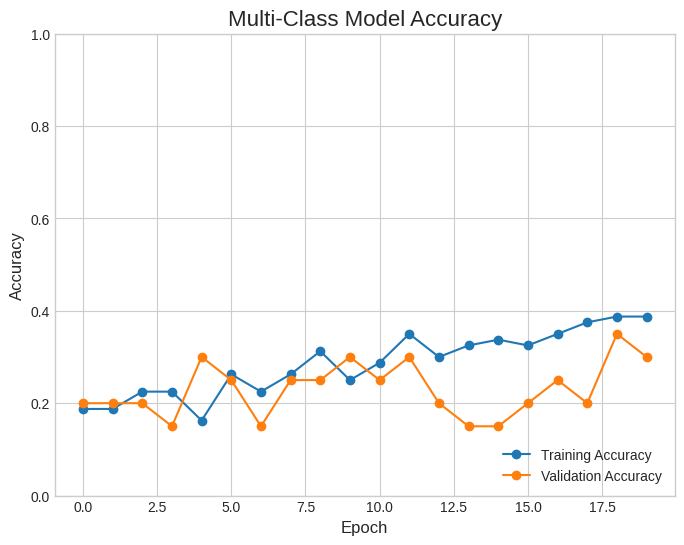

✅ Loss plot saved to 'multiclass_model_loss_plot.png'


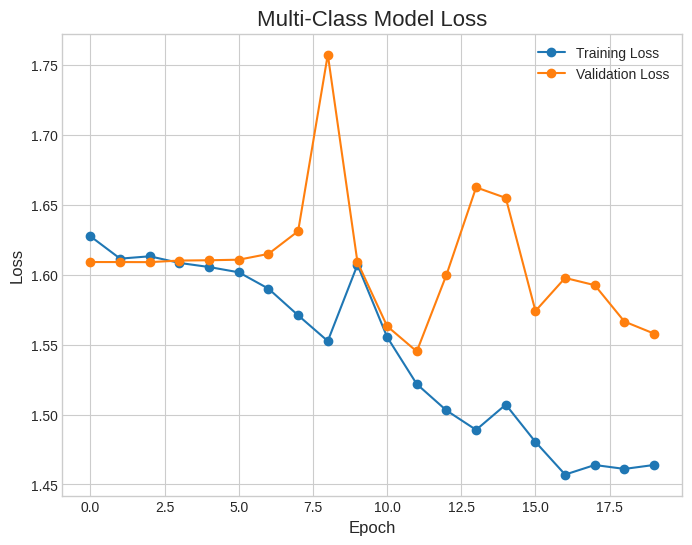

In [ ]:
# --- Plot the training and validation accuracy and loss ---
if 'history_multiclass' in locals():
    acc = history_multiclass.history['accuracy']
    val_acc = history_multiclass.history['val_accuracy']
    loss = history_multiclass.history['loss']
    val_loss = history_multiclass.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.style.use('seaborn-v0_8-whitegrid')
    
    # --- Create and Save the Accuracy Plot ---
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Multi-Class Model Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim([0, 1])
    plt.savefig('multiclass_model_accuracy_plot.png', dpi=300, bbox_inches='tight')
    print("✅ Accuracy plot saved to 'multiclass_model_accuracy_plot.png'")
    plt.show()

    # --- Create and Save the Loss Plot ---
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Multi-Class Model Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.savefig('multiclass_model_loss_plot.png', dpi=300, bbox_inches='tight')
    print("✅ Loss plot saved to 'multiclass_model_loss_plot.png'")
    plt.show()

else:
    print("Training history not found. Please run the training cell (Cell 18) first.")

 1/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
--- Multi-Class Classifier Performance on Validation Set ---
              precision    recall  f1-score   support

         DCM       0.20      0.50      0.29         4
         HCM       0.00      0.00      0.00         4
        MINF       0.29      0.50      0.36         4
         NOR       0.50      0.25      0.33         4
          RV       1.00      0.25      0.40         4

    accuracy                           0.30        20
   macro avg       0.40      0.30      0.28        20
weighted avg       0.40      0.30      0.28        20


✅ Confusion matrix plot saved to 'multiclass_confusion_matrix.png'


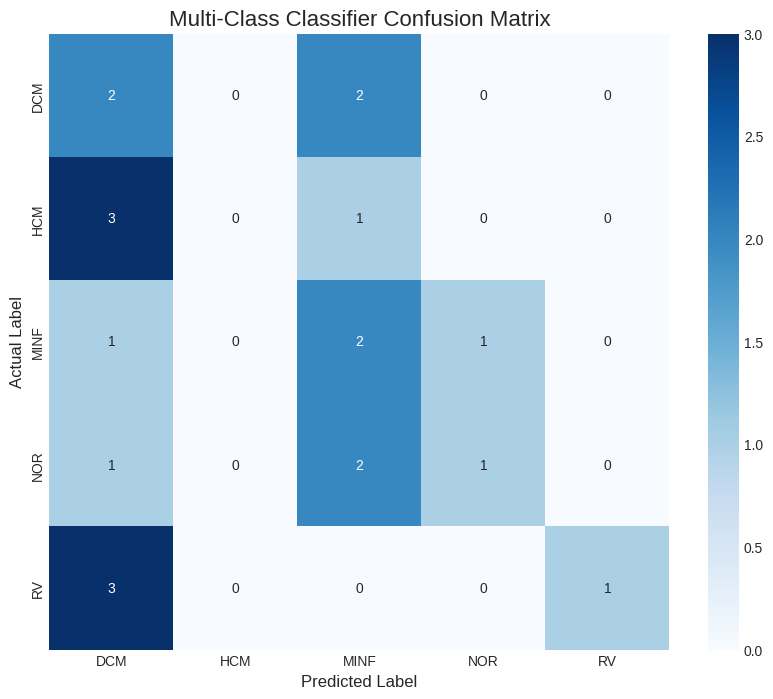

In [ ]:
# --- Make predictions on the validation set ---
# The output will be a probability distribution over the 5 classes for each sample.
y_pred_probs_mc = model_multiclass.predict(val_ds_mc)

# Use np.argmax to find the class with the highest probability for each prediction
y_pred_mc = np.argmax(y_pred_probs_mc, axis=1)

# --- Generate and print the classification report ---
print("--- Multi-Class Classifier Performance on Validation Set ---")
report_mc = classification_report(y_val_mc, y_pred_mc, target_names=le_mc.classes_, zero_division=0)
print(report_mc)

# --- Calculate and plot the Confusion Matrix ---
cm_mc = confusion_matrix(y_val_mc, y_pred_mc)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_mc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_mc.classes_, yticklabels=le_mc.classes_)

plt.title('Multi-Class Classifier Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# --- Save the plot for your paper ---
plt.savefig('multiclass_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrix plot saved to 'multiclass_confusion_matrix.png'")
plt.show()

In [ ]:
def create_multiclass_st_model_regularized(input_shape, num_classes):
    """
    Creates a regularized 3D CNN-LSTM model with a Dropout layer.
    """
    inputs = Input(shape=input_shape)

    # Feature extraction part remains the same
    cnn = TimeDistributed(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding='same'))(inputs)
    cnn = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2)))(cnn)
    cnn = TimeDistributed(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding='same'))(cnn)
    cnn = TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2)))(cnn)
    cnn = TimeDistributed(tf.keras.layers.GlobalAveragePooling3D())(cnn)
    lstm = LSTM(32, return_sequences=False)(cnn)

    # --- Add a Dropout layer for regularization ---
    # This randomly sets 50% of input units to 0 at each update during training.
    x = tf.keras.layers.Dropout(0.5)(lstm)
    
    # The final Dense layer now takes input from the Dropout layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# --- Create and Compile the Regularized Model ---
INPUT_SHAPE = (None, IMG_SIZE[0], IMG_SIZE[1], None, 1)
NUM_CLASSES = 5

model_multiclass_aug = create_multiclass_st_model_regularized(INPUT_SHAPE, NUM_CLASSES)

model_multiclass_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("--- Regularized Multi-Class Model Architecture ---")
model_multiclass_aug.summary()

--- Regularized Multi-Class Model Architecture ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ None, 1)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, None, 64, 64,   │           224 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, None, 32, 32,   │             0 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, None, 32, 32,   │         3,472 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, None, 16, 16,   │             0 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,133 (39.58 KB)

 Trainable params: 10,133 (39.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # --- Set Training Parameters ---
# EPOCHS = 30 # Increased epochs since we are using augmentation

# print("--- Starting Training with Augmented Data ---")

# # --- Train the model ---
# # We pass the new model and the new augmented data pipelines
# history_multiclass_aug = model_multiclass_aug.fit(
#     train_ds_aug,
#     epochs=EPOCHS,
#     validation_data=val_ds_aug,
#     verbose=1
# )

# print("\n--- Model Training Complete ---")

--- Starting Training with Augmented Data ---
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2358 - loss: 1.6132WARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - accuracy: 0.2500 - loss: 1.6169 - val_accuracy: 0.2000 - val_loss: 1.6153
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.2125 - loss: 1.6109 - val_accuracy: 0.2000 - val_loss: 1.6114
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 322ms/step - accuracy: 0.1875 - loss: 1.6106 - val_accuracy: 0.2000 - val_loss: 1.6130
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 296ms/step - accuracy: 0.2125 - loss: 1.6119 - val_accuracy: 0.2500 - val_loss: 1.6120
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.2500 - loss: 1.6111 - val_accuracy: 0.2500 - val_loss: 1.6135
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.2000 - loss: 1.6079 - val_accuracy: 0.3000 - val_loss: 1

In [ ]:
# --- Check if the multi-class model exists before proceeding ---
if 'model_multiclass_aug' in locals():
    # IMPORTANT: Check your model summary from Cell 17 for the correct LSTM layer name.
    # It might be 'lstm_3', 'lstm_4', etc.
    FEATURE_LAYER_NAME_MC = 'lstm_4' #<-- VERIFY AND CHANGE THIS IF NEEDED

    # --- Create the new feature extractor model ---
    feature_extractor_mc = Model(
        inputs=model_multiclass_aug.input,
        outputs=model_multiclass_aug.get_layer(FEATURE_LAYER_NAME_MC).output
    )

    feature_extractor_mc.compile()

    print(f"--- Multi-Class Feature Extractor (outputting from '{FEATURE_LAYER_NAME_MC}') ---")
    feature_extractor_mc.summary()
else:
    print("Multi-class model 'model_multiclass_aug' not found. Please run the training cells first.")

--- Multi-Class Feature Extractor (outputting from 'lstm_4') ---


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ None, 1)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, None, 64, 64,   │           224 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, None, 32, 32,   │             0 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, None, 32, 32,   │         3,472 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, None, 16, 16,   │             0 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │         6,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,968 (38.94 KB)

 Trainable params: 9,968 (38.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Check if the necessary variables exist ---
if 'feature_extractor_mc' in locals() and 'train_ds_mc' in locals():
    print("--- Extracting features from the multi-class training set ---")
    X_train_features_mc = feature_extractor_mc.predict(train_ds_mc)

    print("\n--- Extracting features from the multi-class validation set ---")
    X_val_features_mc = feature_extractor_mc.predict(val_ds_mc)

    print("\n--- Feature Extraction Complete ---")
    print(f"Shape of training features: {X_train_features_mc.shape}")
    print(f"Shape of validation features: {X_val_features_mc.shape}")
else:
    print("Could not find the multi-class model or data pipelines. Please run the previous cells first.")

--- Extracting features from the multi-class training set ---
 1/80 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step

--- Extracting features from the multi-class validation set ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step

--- Feature Extraction Complete ---
Shape of training features: (80, 32)
Shape of validation features: (20, 32)


In [ ]:
# --- Create and Train the Multi-Class XGBoost Classifier ---
print("--- Training the Multi-Class XGBoost Classifier ---")

# 1. Instantiate the XGBoost model for multi-class classification
xgb_classifier_mc = xgb.XGBClassifier(
    objective='multi:softmax', # Use 'multi:softmax' for multi-class problems
    num_class=5,               # Explicitly tell it there are 5 classes
    use_label_encoder=False, 
    eval_metric='mlogloss'
)

# 2. Train the model on our extracted multi-class features
xgb_classifier_mc.fit(X_train_features_mc, y_train_mc)

print("\n✅ Multi-class XGBoost model training complete.")

--- Training the Multi-Class XGBoost Classifier ---

✅ Multi-class XGBoost model training complete.


/home/harishankar/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:55:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
# --- Make predictions on the validation set features ---
y_pred_xgb_mc = xgb_classifier_mc.predict(X_val_features_mc)

# --- Generate and print the classification report ---
print("--- Hybrid Multi-Class Model Performance on Validation Set ---")
report_mc_xgb = classification_report(y_val_mc, y_pred_xgb_mc, target_names=le_mc.classes_, zero_division=0)
print(report_mc_xgb)

# --- Calculate and plot the Confusion Matrix ---
cm_xgb_mc = confusion_matrix(y_val_mc, y_pred_xgb_mc)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb_mc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_mc.classes_, yticklabels=le_mc.classes_)

plt.title('Hybrid Multi-Class Model Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# --- Save the plot for your paper ---
plt.savefig('multiclass_hybrid_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✅ Final confusion matrix plot saved to 'multiclass_hybrid_confusion_matrix.png'")
plt.show()

NameError: name 'xgb_classifier_mc' is not defined

In [ ]:
# import pickle

# # --- Ensure the save directory exists ---
# os.makedirs('saved_models', exist_ok=True)

# # --- Define new file paths for this specific model ---
# AUG_MODEL_PATH = 'saved_models/multiclass_classifier_augmented_model.keras'
# AUG_HISTORY_PATH = 'saved_models/multiclass_classifier_augmented_history.pkl'

# # --- Check if the model and history exist before saving ---
# if 'model_multiclass_aug' in locals() and 'history_multiclass_aug' in locals():
#     # --- Save the entire model ---
#     # This saves the architecture, learned weights, and optimizer state.
#     model_multiclass_aug.save(AUG_MODEL_PATH)

#     # --- Save the training history dictionary ---
#     with open(AUG_HISTORY_PATH, 'wb') as file:
#         pickle.dump(history_multiclass_aug.history, file)

#     print(f"✅ Augmented model saved to: {AUG_MODEL_PATH}")
#     print(f"✅ Augmented model's history saved to: {AUG_HISTORY_PATH}")
# else:
#     print("Could not find the augmented model or its history. Please ensure the training cell was run.")

✅ Augmented model saved to: saved_models/multiclass_classifier_augmented_model.keras
✅ Augmented model's history saved to: saved_models/multiclass_classifier_augmented_history.pkl


In [6]:
# --- Define the path to the model we want to test ---
# This should be the last model we saved.
MODEL_TO_TEST_PATH = 'saved_models/multiclass_classifier_augmented_model.keras'

# --- Load the model from the file ---
if os.path.exists(MODEL_TO_TEST_PATH):
    print(f"--- Loading model from: {MODEL_TO_TEST_PATH} ---")
    loaded_model = tf.keras.models.load_model(MODEL_TO_TEST_PATH)
    
    # Print the summary to confirm it's the correct model
    loaded_model.summary()
else:
    print(f"Model file not found at {MODEL_TO_TEST_PATH}. Please ensure the model was saved correctly.")

--- Loading model from: saved_models/multiclass_classifier_augmented_model.keras ---


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, 64, 64,   │             0 │
│                                 │ None, 1)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, None, 64, 64,   │           224 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, None, 32, 32,   │             0 │
│ (TimeDistributed)               │ None, 8)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, None, 32, 32,   │         3,472 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, None, 16, 16,   │             0 │
│ (TimeDistributed)               │ None, 16)              │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.76 KB)

 Trainable params: 10,133 (39.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,268 (79.18 KB)

In [7]:
# --- Scan the 'testing' directory to get the file paths and labels ---
test_paths = []
test_labels_str = []

subset_path = os.path.join(ACDC_DATA_PATH, 'testing') # <-- Using the 'testing' folder
patient_folders = sorted([d for d in os.listdir(subset_path) if d.startswith('patient')])

print("--- Scanning test data folder ---")
for patient_dir in tqdm(patient_folders, desc="Scanning test folders"):
    patient_path = os.path.join(subset_path, patient_dir)
    try:
        info_path = os.path.join(patient_path, 'Info.cfg')
        with open(info_path, 'r') as f:
            lines = f.readlines()
        label = next(line.split(':')[1].strip() for line in lines if line.startswith('Group'))
        
        img_file_name = next(f for f in os.listdir(patient_path) if img_regex.match(f))
        img_path = os.path.join(patient_path, img_file_name)
        
        test_paths.append(img_path)
        test_labels_str.append(label)
    except (StopIteration, FileNotFoundError):
        continue

# --- IMPORTANT: Use the SAME LabelEncoder from training ---
# We use .transform() here, NOT .fit_transform(), to ensure the class-to-number
# mapping is identical to the training set.
y_test = le_mc.transform(test_labels_str)

# --- Create the tf.data pipeline for the test set ---
test_ds = configure_dataset(test_paths, y_test) # Use our existing function

print(f"\n✅ Test data pipeline created with {len(test_paths)} samples.")

--- Scanning test data folder ---


Scanning test folders:   0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'le_mc' is not defined

--- Redefining helper functions ---

--- Starting Binary Model Analysis ---


I0000 00:00:1758597218.628278   13544 cuda_dnn.cc:529] Loaded cuDNN version 91002


1/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step
Binary model predictions are ready.


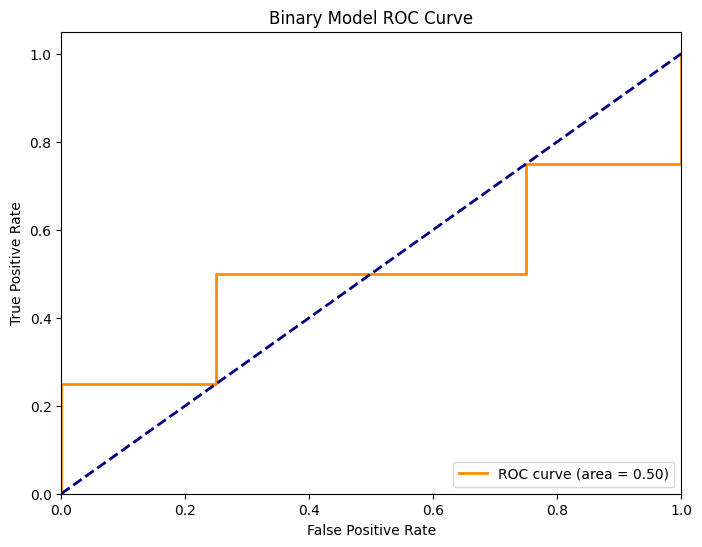

✅ Binary ROC curve saved.


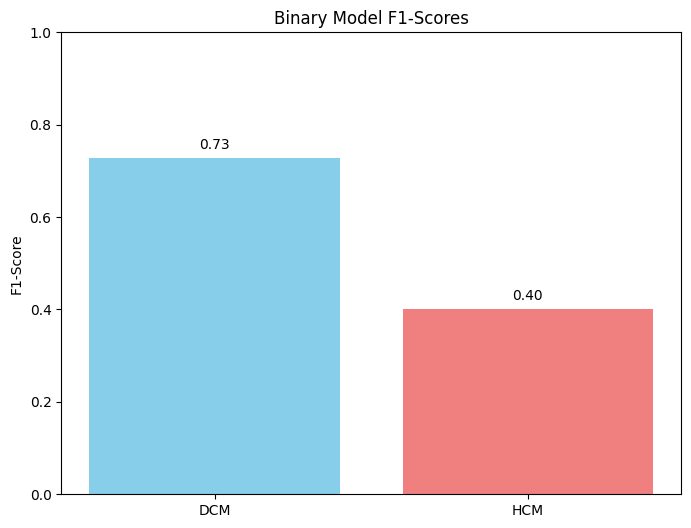

✅ Binary F1-score chart saved.

--- Starting Augmented Multi-Class Model Analysis ---
 1/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step
Multi-class model predictions are ready.


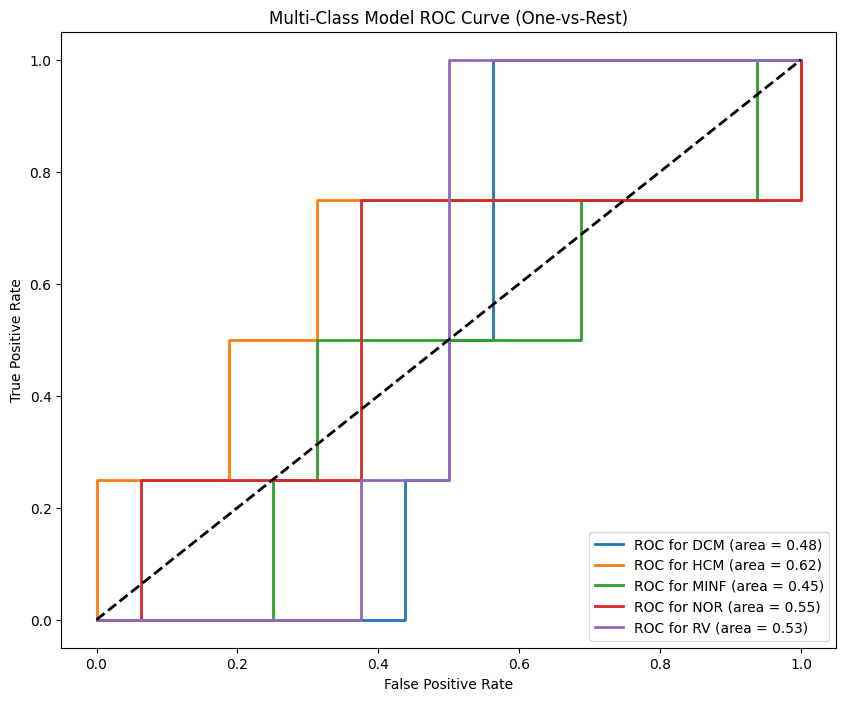

✅ Multi-class ROC curve saved.


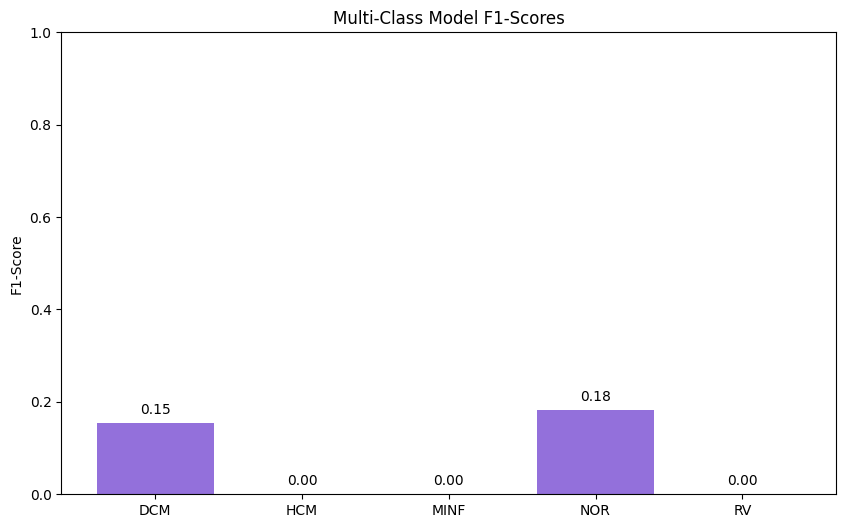

✅ Multi-class F1-score chart saved.


In [19]:
import os
import pickle
import numpy as np
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, classification_report
from tqdm.notebook import tqdm
import re

# --- Configuration (Set these to match your project) ---
ACDC_DATA_PATH = 'data'
IMG_SIZE = (64, 64)
NUM_CLASSES = 5

# ==============================================================================
# SECTION 1: REDEFINE ALL NECESSARY HELPER FUNCTIONS
# ==============================================================================
print("--- Redefining helper functions ---")

# --- Augmentation Layers (defined once) ---
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomWidth(0.05),
    tf.keras.layers.RandomHeight(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
])

def augment_slice(slice_2d):
    slice_3d = tf.expand_dims(slice_2d, axis=-1)
    augmented_slice_3d = data_augmentation_layers(slice_3d, training=True)
    return tf.squeeze(augmented_slice_3d, axis=-1)

def parse_image(file_path):
    def _load_nifti(path_tensor):
        path = path_tensor.numpy().decode()
        img_nifti = nib.load(path)
        img_data = img_nifti.get_fdata().astype(np.float32)
        return img_data
    img_data = tf.py_function(_load_nifti, [file_path], Tout=tf.float32)

    def _resize_volume(volume_3d):
        volume_3d_ch = tf.expand_dims(volume_3d, axis=-1)
        volume_3d_ch_transposed = tf.transpose(volume_3d_ch, [2, 0, 1, 3])
        resized_vol = tf.image.resize(volume_3d_ch_transposed, IMG_SIZE)
        resized_vol_transposed = tf.transpose(resized_vol, [1, 2, 0, 3])
        return tf.squeeze(resized_vol_transposed, axis=-1)

    img_transposed_time_first = tf.transpose(img_data, (3, 0, 1, 2))
    processed_img = tf.map_fn(_resize_volume, img_transposed_time_first, fn_output_signature=tf.float32)
    
    min_val, max_val = tf.reduce_min(processed_img), tf.reduce_max(processed_img)
    if max_val > min_val:
        processed_img = (processed_img - min_val) / (max_val - min_val)
    processed_img = tf.expand_dims(processed_img, axis=-1)
    return processed_img

def parse_image_and_augment(file_path, label):
    img_tensor = parse_image(file_path)
    def _augment_volume_in_time(volume_4d):
        original_shape = tf.shape(volume_4d)
        t, h, w, z = original_shape[0], original_shape[1], original_shape[2], original_shape[3]
        slices_2d_batch = tf.reshape(tf.squeeze(volume_4d, axis=-1), [-1, h, w])
        augmented_slices_2d_batch = tf.map_fn(augment_slice, slices_2d_batch)
        augmented_volume = tf.reshape(augmented_slices_2d_batch, (t, h, w, z))
        return tf.expand_dims(augmented_volume, axis=-1)
    augmented_img = _augment_volume_in_time(img_tensor)
    return augmented_img, label

def configure_dataset(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    
    if augment:
        ds = ds.map(parse_image_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda p, l: (parse_image(p), l), num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.padded_batch(
        batch_size=1, 
        padded_shapes=([None, IMG_SIZE[0], IMG_SIZE[1], None, 1], [])
    )
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# ==============================================================================
# SECTION 2: BINARY MODEL ANALYSIS
# ==============================================================================
print("\n--- Starting Binary Model Analysis ---")

# --- Regenerate the validation data paths and labels ---
binary_paths = []
binary_labels_str = []
img_regex = re.compile(r'patient\d+_4d\.nii(\.gz)?$')
for patient_dir in sorted([d for d in os.listdir(os.path.join(ACDC_DATA_PATH, 'training')) if d.startswith('patient')]):
    try:
        info_path = os.path.join(ACDC_DATA_PATH, 'training', patient_dir, 'Info.cfg')
        with open(info_path, 'r') as f: label = next(line.split(':')[1].strip() for line in f if line.startswith('Group'))
        if label in ['HCM', 'DCM']:
            img_file_name = next(f for f in os.listdir(os.path.join(ACDC_DATA_PATH, 'training', patient_dir)) if img_regex.match(f))
            binary_paths.append(os.path.join(ACDC_DATA_PATH, 'training', patient_dir, img_file_name))
            binary_labels_str.append(label)
    except: continue
le_binary = LabelEncoder().fit(binary_labels_str)
binary_labels = le_binary.transform(binary_labels_str)
_, paths_val, _, y_val = train_test_split(binary_paths, binary_labels, test_size=0.2, random_state=42, stratify=binary_labels)

# --- Load Model and Get Predictions ---
binary_model_path = 'saved_models/binary_classifier_model.keras'
loaded_binary_model = tf.keras.models.load_model(binary_model_path)
val_ds_binary = configure_dataset(paths_val, y_val)
y_pred_probs_binary = loaded_binary_model.predict(val_ds_binary)
y_pred_binary = (y_pred_probs_binary > 0.5).astype(int)
print("Binary model predictions are ready.")

# --- Generate Binary ROC Curve ---
fpr, tpr, _ = roc_curve(y_val, y_pred_probs_binary)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6)); plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'); plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('Binary Model ROC Curve'); plt.legend(loc="lower right"); plt.savefig('binary_model_roc_curve.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Binary ROC curve saved.")

# --- Generate Binary F1-Score Bar Chart ---
report_dict_binary = classification_report(y_val, y_pred_binary, target_names=le_binary.classes_, output_dict=True, zero_division=0)
f1_scores_binary = {label: report_dict_binary[label]['f1-score'] for label in le_binary.classes_}
plt.figure(figsize=(8, 6)); plt.bar(f1_scores_binary.keys(), f1_scores_binary.values(), color=['skyblue', 'lightcoral']); plt.title('Binary Model F1-Scores'); plt.ylabel('F1-Score'); plt.ylim([0, 1.0]);
for i, (label, score) in enumerate(f1_scores_binary.items()): plt.text(i, score + 0.02, f'{score:.2f}', ha='center')
plt.savefig('binary_model_f1_chart.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Binary F1-score chart saved.")


# ==============================================================================
# SECTION 3: AUGMENTED MULTI-CLASS MODEL ANALYSIS
# ==============================================================================
print("\n--- Starting Augmented Multi-Class Model Analysis ---")

# --- Regenerate the validation data paths and labels ---
mc_paths = []
mc_labels_str = []
for patient_dir in sorted([d for d in os.listdir(os.path.join(ACDC_DATA_PATH, 'training')) if d.startswith('patient')]):
    try:
        info_path = os.path.join(ACDC_DATA_PATH, 'training', patient_dir, 'Info.cfg')
        with open(info_path, 'r') as f: label = next(line.split(':')[1].strip() for line in f if line.startswith('Group'))
        img_file_name = next(f for f in os.listdir(os.path.join(ACDC_DATA_PATH, 'training', patient_dir)) if img_regex.match(f))
        mc_paths.append(os.path.join(ACDC_DATA_PATH, 'training', patient_dir, img_file_name))
        mc_labels_str.append(label)
    except: continue
le_mc = LabelEncoder().fit(mc_labels_str)
mc_labels = le_mc.transform(mc_labels_str)
_, paths_val_mc, _, y_val_mc = train_test_split(mc_paths, mc_labels, test_size=0.2, random_state=42, stratify=mc_labels)

# --- Load Model and Get Predictions ---
aug_model_path = 'saved_models/multiclass_classifier_augmented_model.keras'
loaded_aug_model = tf.keras.models.load_model(aug_model_path)
val_ds_mc = configure_dataset(paths_val_mc, y_val_mc) # Note: augment=False by default
y_pred_probs_mc = loaded_aug_model.predict(val_ds_mc)
y_pred_mc = np.argmax(y_pred_probs_mc, axis=1)
y_val_binarized = label_binarize(y_val_mc, classes=range(NUM_CLASSES))
print("Multi-class model predictions are ready.")

# --- Generate Multi-Class ROC Curve ---
fpr, tpr, roc_auc = dict(), dict(), dict()
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_probs_mc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {le_mc.classes_[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('Multi-Class Model ROC Curve (One-vs-Rest)'); plt.legend(loc="lower right"); plt.savefig('multiclass_model_roc_curve.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Multi-class ROC curve saved.")

# --- Generate Multi-Class F1-Score Bar Chart ---
report_dict_mc = classification_report(y_val_mc, y_pred_mc, target_names=le_mc.classes_, output_dict=True, zero_division=0)
f1_scores_mc = {label: report_dict_mc[label]['f1-score'] for label in le_mc.classes_}
plt.figure(figsize=(10, 6)); plt.bar(f1_scores_mc.keys(), f1_scores_mc.values(), color='mediumpurple'); plt.title('Multi-Class Model F1-Scores'); plt.ylabel('F1-Score'); plt.ylim([0, 1.0]);
for i, (label, score) in enumerate(f1_scores_mc.items()): plt.text(i, score + 0.02, f'{score:.2f}', ha='center')
plt.savefig('multiclass_model_f1_chart.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Multi-class F1-score chart saved.")

--- Redefining helper functions ---

--- Starting Binary Model Analysis ---
1/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Binary model predictions are ready.


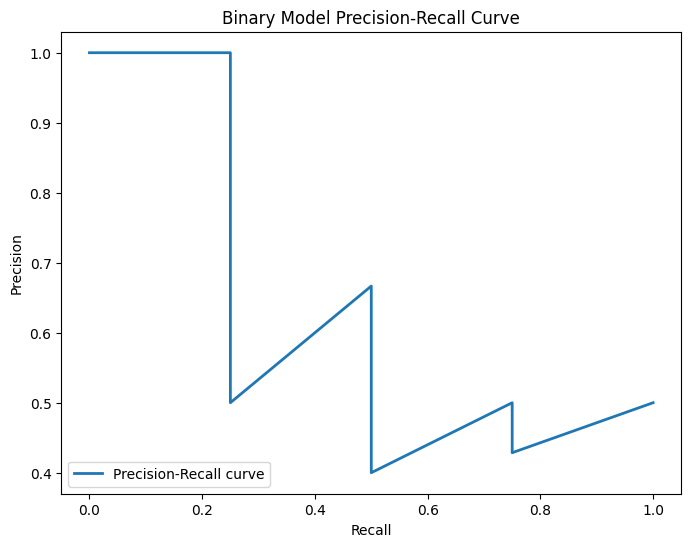

✅ Binary Precision-Recall curve saved.


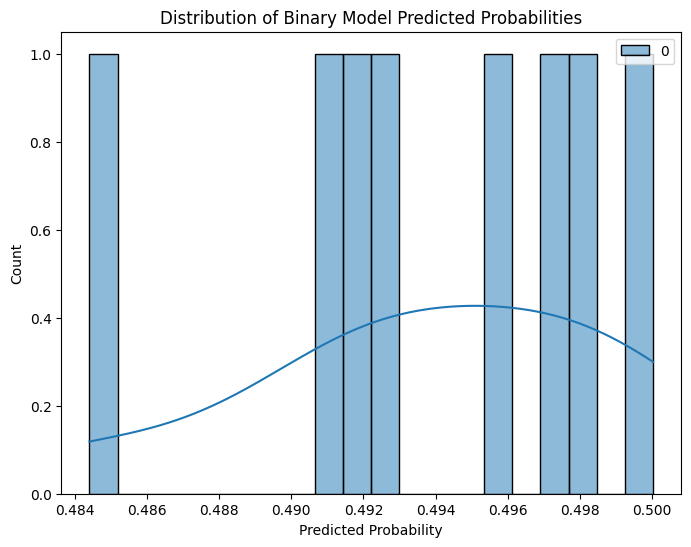

✅ Binary probability distribution plot saved.
1/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


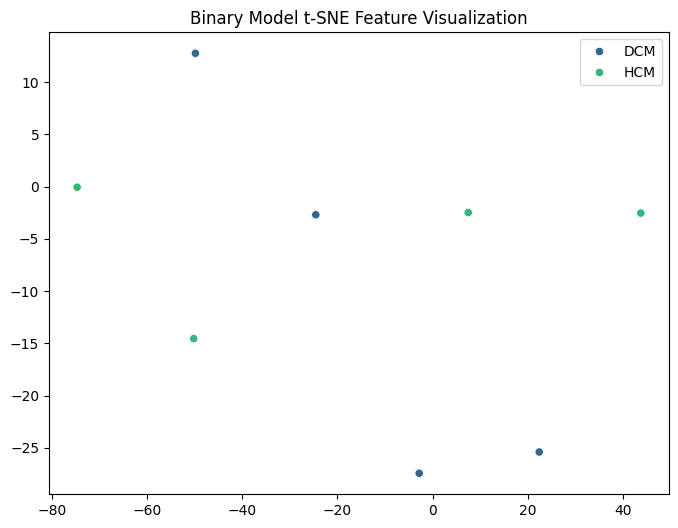

✅ Binary t-SNE plot saved.

--- Starting Augmented Multi-Class Model Analysis ---
 1/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step
Multi-class model predictions are ready.


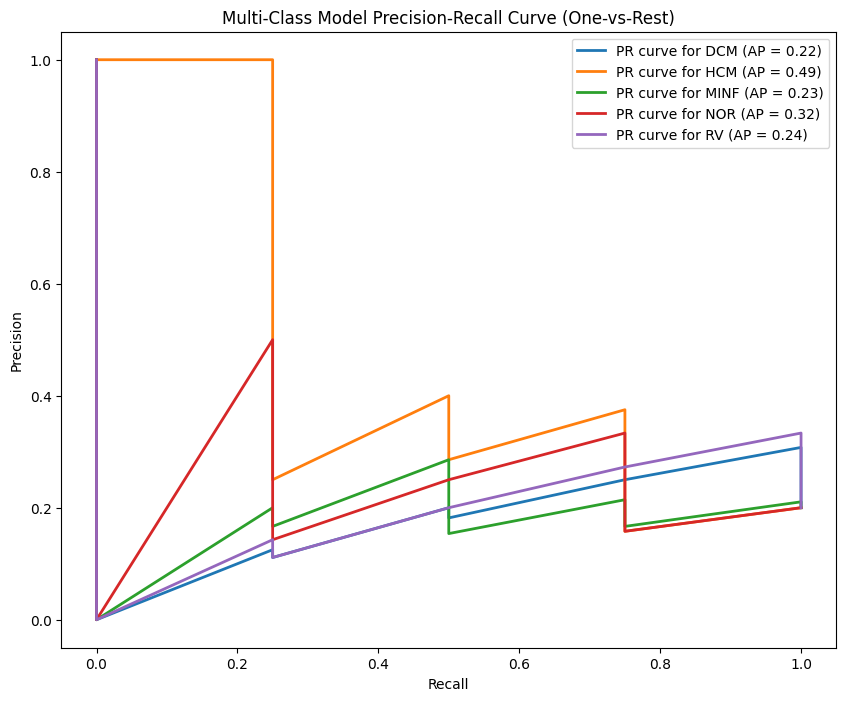

✅ Multi-class Precision-Recall curve saved.


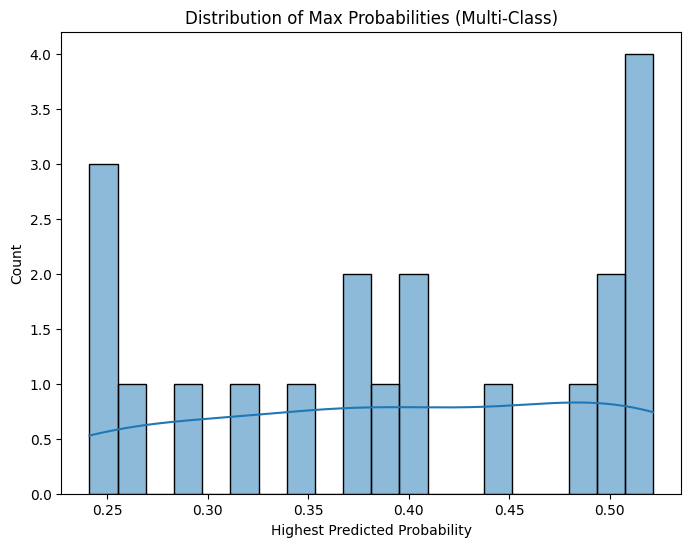

✅ Multi-class probability distribution plot saved.
 1/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/stepWARNING:tensorflow:Using a while_loop for converting Conv3D cause there is no registered converter for this op.
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


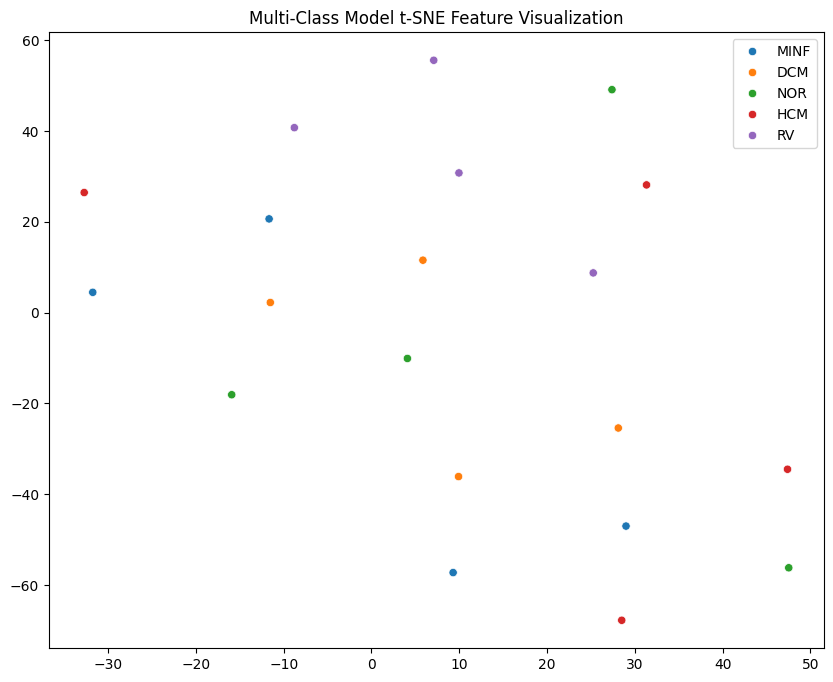

✅ Multi-class t-SNE plot saved.


In [20]:
import os
import pickle
import numpy as np
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import re

# --- Configuration (Set these to match your project) ---
ACDC_DATA_PATH = 'data'
IMG_SIZE = (64, 64)
NUM_CLASSES = 5

# ==============================================================================
# SECTION 1: REDEFINE ALL NECESSARY HELPER FUNCTIONS
# ==============================================================================
print("--- Redefining helper functions ---")

data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.02), tf.keras.layers.RandomWidth(0.05),
    tf.keras.layers.RandomHeight(0.05), tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
])

def augment_slice(slice_2d):
    slice_3d = tf.expand_dims(slice_2d, axis=-1)
    return tf.squeeze(data_augmentation_layers(slice_3d, training=True), axis=-1)

def parse_image(file_path):
    def _load_nifti(path_tensor):
        path = path_tensor.numpy().decode()
        img_data = nib.load(path).get_fdata().astype(np.float32)
        return img_data
    img_data = tf.py_function(_load_nifti, [file_path], Tout=tf.float32)

    def _resize_volume(volume_3d):
        vol_ch = tf.expand_dims(volume_3d, axis=-1)
        vol_transposed = tf.transpose(vol_ch, [2, 0, 1, 3])
        resized_vol = tf.image.resize(vol_transposed, IMG_SIZE)
        return tf.squeeze(tf.transpose(resized_vol, [1, 2, 0, 3]), axis=-1)

    img_transposed = tf.transpose(img_data, (3, 0, 1, 2))
    processed_img = tf.map_fn(_resize_volume, img_transposed, fn_output_signature=tf.float32)
    min_val, max_val = tf.reduce_min(processed_img), tf.reduce_max(processed_img)
    if max_val > min_val:
        processed_img = (processed_img - min_val) / (max_val - min_val)
    return tf.expand_dims(processed_img, axis=-1)

def parse_image_and_augment(file_path, label):
    img_tensor = parse_image(file_path)
    def _augment_volume_in_time(volume_4d):
        shape = tf.shape(volume_4d)
        t, h, w, z = shape[0], shape[1], shape[2], shape[3]
        slices_2d = tf.reshape(tf.squeeze(volume_4d, axis=-1), [-1, h, w])
        aug_slices_2d = tf.map_fn(augment_slice, slices_2d)
        return tf.expand_dims(tf.reshape(aug_slices_2d, (t, h, w, z)), axis=-1)
    return _augment_volume_in_time(img_tensor), label

def configure_dataset(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle: ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(parse_image_and_augment if augment else lambda p, l: (parse_image(p), l), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.padded_batch(batch_size=1, padded_shapes=([None, IMG_SIZE[0], IMG_SIZE[1], None, 1], []))
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# ==============================================================================
# SECTION 2: BINARY MODEL ANALYSIS
# ==============================================================================
print("\n--- Starting Binary Model Analysis ---")

# --- Regenerate Validation Data ---
binary_paths, binary_labels_str = [], []
img_regex = re.compile(r'patient\d+_4d\.nii(\.gz)?$')
for patient_dir in sorted([d for d in os.listdir(os.path.join(ACDC_DATA_PATH, 'training')) if d.startswith('patient')]):
    try:
        info_path = os.path.join(ACDC_DATA_PATH, 'training', patient_dir, 'Info.cfg')
        with open(info_path, 'r') as f: label = next(line.split(':')[1].strip() for line in f if line.startswith('Group'))
        if label in ['HCM', 'DCM']:
            img_file = next(f for f in os.listdir(os.path.join(ACDC_DATA_PATH, 'training', patient_dir)) if img_regex.match(f))
            binary_paths.append(os.path.join(ACDC_DATA_PATH, 'training', patient_dir, img_file))
            binary_labels_str.append(label)
    except: continue
le_binary = LabelEncoder().fit(binary_labels_str)
binary_labels = le_binary.transform(binary_labels_str)
_, paths_val, _, y_val = train_test_split(binary_paths, binary_labels, test_size=0.2, random_state=42, stratify=binary_labels)
val_ds_binary = configure_dataset(paths_val, y_val)

# --- Load Model and Get Predictions ---
binary_model = tf.keras.models.load_model('saved_models/binary_classifier_model.keras')
y_pred_probs_binary = binary_model.predict(val_ds_binary)
print("Binary model predictions are ready.")

# --- Plot 1: Binary Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_val, y_pred_probs_binary)
plt.figure(figsize=(8, 6)); plt.plot(recall, precision, lw=2, label='Precision-Recall curve'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Binary Model Precision-Recall Curve'); plt.legend(loc="lower left"); plt.savefig('binary_model_pr_curve.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Binary Precision-Recall curve saved.")

# --- Plot 2: Binary Probability Distribution ---
plt.figure(figsize=(8, 6)); sns.histplot(y_pred_probs_binary, bins=20, kde=True); plt.title('Distribution of Binary Model Predicted Probabilities'); plt.xlabel('Predicted Probability'); plt.savefig('binary_model_prob_dist.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Binary probability distribution plot saved.")

# --- Plot 3: Binary t-SNE Feature Visualization ---
binary_feature_extractor = tf.keras.Model(inputs=binary_model.input, outputs=binary_model.layers[-2].output) # Output of LSTM
X_val_features = binary_feature_extractor.predict(val_ds_binary)
tsne_results = TSNE(n_components=2, perplexity=min(5, len(X_val_features)-1), random_state=42).fit_transform(X_val_features)
plt.figure(figsize=(8, 6)); sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=le_binary.inverse_transform(y_val), palette='viridis'); plt.title('Binary Model t-SNE Feature Visualization'); plt.savefig('binary_model_tsne.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Binary t-SNE plot saved.")

# ==============================================================================
# SECTION 3: AUGMENTED MULTI-CLASS MODEL ANALYSIS
# ==============================================================================
print("\n--- Starting Augmented Multi-Class Model Analysis ---")

# --- Regenerate Validation Data ---
mc_paths, mc_labels_str = [], []
for patient_dir in sorted([d for d in os.listdir(os.path.join(ACDC_DATA_PATH, 'training')) if d.startswith('patient')]):
    try:
        info_path = os.path.join(ACDC_DATA_PATH, 'training', patient_dir, 'Info.cfg')
        with open(info_path, 'r') as f: label = next(line.split(':')[1].strip() for line in f if line.startswith('Group'))
        img_file = next(f for f in os.listdir(os.path.join(ACDC_DATA_PATH, 'training', patient_dir)) if img_regex.match(f))
        mc_paths.append(os.path.join(ACDC_DATA_PATH, 'training', patient_dir, img_file))
        mc_labels_str.append(label)
    except: continue
le_mc = LabelEncoder().fit(mc_labels_str)
mc_labels = le_mc.transform(mc_labels_str)
_, paths_val_mc, _, y_val_mc = train_test_split(mc_paths, mc_labels, test_size=0.2, random_state=42, stratify=mc_labels)
val_ds_mc = configure_dataset(paths_val_mc, y_val_mc)

# --- Load Model and Get Predictions ---
aug_model = tf.keras.models.load_model('saved_models/multiclass_classifier_augmented_model.keras')
y_pred_probs_mc = aug_model.predict(val_ds_mc)
y_val_binarized = label_binarize(y_val_mc, classes=range(NUM_CLASSES))
print("Multi-class model predictions are ready.")

# --- Plot 4: Multi-Class Precision-Recall Curve ---
precision, recall, avg_precision = dict(), dict(), dict()
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_pred_probs_mc[:, i])
    avg_precision[i] = average_precision_score(y_val_binarized[:, i], y_pred_probs_mc[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve for {le_mc.classes_[i]} (AP = {avg_precision[i]:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Multi-Class Model Precision-Recall Curve (One-vs-Rest)'); plt.legend(loc="best"); plt.savefig('multiclass_model_pr_curve.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Multi-class Precision-Recall curve saved.")

# --- Plot 5: Multi-Class Probability Distribution ---
max_probs = np.max(y_pred_probs_mc, axis=1)
plt.figure(figsize=(8, 6)); sns.histplot(max_probs, bins=20, kde=True); plt.title('Distribution of Max Probabilities (Multi-Class)'); plt.xlabel('Highest Predicted Probability'); plt.savefig('multiclass_model_prob_dist.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Multi-class probability distribution plot saved.")

# --- Plot 6: Multi-Class t-SNE Feature Visualization ---
mc_feature_extractor = tf.keras.Model(inputs=aug_model.input, outputs=aug_model.layers[-2].output) # Output of Dropout/LSTM
X_val_features_mc = mc_feature_extractor.predict(val_ds_mc)
tsne_results_mc = TSNE(n_components=2, perplexity=min(15, len(X_val_features_mc)-1), random_state=42).fit_transform(X_val_features_mc)
plt.figure(figsize=(10, 8)); sns.scatterplot(x=tsne_results_mc[:,0], y=tsne_results_mc[:,1], hue=le_mc.inverse_transform(y_val_mc), palette='tab10'); plt.title('Multi-Class Model t-SNE Feature Visualization'); plt.savefig('multiclass_model_tsne.png', dpi=300, bbox_inches='tight'); plt.show()
print("✅ Multi-class t-SNE plot saved.")